In [1]:
import pandas as pd
import numpy as np
import requests
from nba_api.stats.endpoints import shotchartdetail
import json
import matplotlib.pyplot as plt
import os

In [2]:
os.chdir("C:/Users/DELL/Desktop")

In [3]:
gamelog = pd.read_csv('gamelog.csv')

In [4]:
gamelog.head(10)

,Date,Age,Tm,Opp,Result,Game Type,Seasontype,GS,MP,FG,...,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,2020/12/23,35-231,PHO,DAL,W (+4),NaN,regular,1,27:45:00,3,...,10.8,8,26.4,3.4,0,23.3,20.5,85,101,-4.4
1,2020/12/26,35-234,PHO,SAC,L (-3),@,regular,1,32:47:00,8,...,13,7.6,60,2.9,2.3,0,27.1,127,102,14.8
2,2020/12/27,35-235,PHO,SAC,W (+16),@,regular,1,27:14:00,4,...,13.6,8.5,54.3,0,0,16.7,19.6,111,106,-2.8
3,2020/12/29,35-237,PHO,NOP,W (+25),NaN,regular,1,23:11,2,...,5.4,4.9,56.7,0,0,25.8,15.7,156,101,8.7
4,2020/12/31,35-239,PHO,UTA,W (+11),@,regular,1,29:50:00,4,...,10.5,7.4,37.2,0,0,18.2,25.6,94,106,-5.1
5,2021/1/1,35-240,PHO,DEN,W (+3),@,regular,1,32:27:00,6,...,16,9.9,31.6,0,2.6,11.4,25.3,138,112,6.8
6,2021/1/3,35-242,PHO,LAC,L (-5),NaN,regular,1,35:46:00,6,...,29.5,15.7,27.8,1.5,2.5,13.4,19.9,115,117,2.1
7,2021/1/6,35-245,PHO,TOR,W (+8),NaN,regular,1,31:36:00,4,...,10.6,7.3,35.8,3.2,0,0,20.2,127,119,-0.8
8,2021/1/8,35-247,PHO,DET,L (-5),@,regular,1,37:51:00,5,...,19.6,10.2,37.1,0,0,15.4,15.5,113,109,-3.3
9,2021/1/9,35-248,PHO,IND,W (+8),@,regular,1,33:06:00,6,...,5.9,3.2,38.9,0,0,8.1,17.3,144,125,-0.1


In [5]:
for column in gamelog.columns:
    print(column,gamelog[column].isnull().values.sum())

#Fill NA valuse Game_Type, FT%, and 3P% have NA
#Game_Type NA = Home Game
#FT% and 3p% NA because there are no shooting 

Date 0
Age 0
Tm 0
Opp 0
Result 0
Game Type 710
Seasontype 0
GS 0
MP 0
FG 0
FGA 0
FG% 0
3P 0
3PA 0
3P% 41
FT 0
FTA 0
FT% 124
ORB 0
DRB 0
TRB 0
AST 0
STL 0
BLK 0
TOV 0
PF 0
PTS 0
GmSc 0
+/- 0
TS% 0
eFG% 0
ORB% 0
DRB% 0
TRB% 0
AST% 0
STL% 0
BLK% 0
TOV% 0
USG% 0
ORtg 0
DRtg 0
BPM 0


In [6]:
#Fill the NA
values = {'Game Type': 'Home', '3P%': 0, 'FT%': 0}
gamelog = gamelog.fillna(value=values)

#ignore the date of age
gamelog['Age'] = gamelog['Age'].astype(str).str[:2].astype(int)

#Keep the result to W (win) or L (Lose)
#Create a new variable result difference to record the game difference
gamelog['Resultdifference'] = gamelog['Result'].astype(str).str[1:].str.replace(r"\(","")
gamelog['Resultdifference'] = gamelog['Resultdifference'].astype(str).str.replace(r"\)","").astype(int)
gamelog['Result'] = gamelog['Result'].astype(str).str[:1]

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  # This is added back by InteractiveShellApp.init_path()


In [7]:
gamelog['GS'].value_counts()

1                1219
Inactive          100
Did Not Dress      62
Did Not Play       21
Not With Team      11
Name: GS, dtype: int64

In [8]:
active = gamelog[gamelog['GS']=='1']
inactive = gamelog[gamelog['GS']!='1']
#active['Result'].groupby(active['Tm']).value_counts()

In [9]:
#Change some variables to int datatypes
active = active.astype({'FG': 'int32', 'FGA': 'int32','3P': 'int32', '3PA': 'int32',
               'FT': 'int32', 'FTA': 'int32','ORB': 'int32', 'DRB': 'int32',
               'TRB': 'int32', 'AST': 'int32','STL': 'int32', 'BLK': 'int32',
               'TOV': 'int32', 'PF': 'int32','PTS': 'int32', '+/-': 'int32',
               'ORtg': 'int32', 'DRtg': 'int32'})

#Change some percentage variables to float datatypes

active = active.astype({'FG%': 'float', '3P%': 'float','FT%': 'float', 'GmSc': 'float',
                       'TS%': 'float', 'eFG%': 'float','ORB%': 'float', 'DRB%': 'float',
                        'TRB%': 'float', 'AST%': 'float','STL%': 'float','BLK%': 'float',
                        'TOV%': 'float','USG%': 'float','BPM': 'float'})
#change mp data type
def min_to_float(x):
    mins = int(x.split(':')[0])
    secs = int(x.split(':')[1])/60.0
    val = mins + secs
    return round(val, 2)

active['MP'] = active['MP'].apply(min_to_float)

#change Date data type
active['Date'] = pd.to_datetime(active['Date'])

In [10]:
active.head(10)

,Date,Age,Tm,Opp,Result,Game Type,Seasontype,GS,MP,FG,...,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM,Resultdifference
0,2020-12-23,35,PHO,DAL,W,Home,regular,1,27.75,3,...,8.0,26.4,3.4,0.0,23.3,20.5,85,101,-4.4,4
1,2020-12-26,35,PHO,SAC,L,@,regular,1,32.78,8,...,7.6,60.0,2.9,2.3,0.0,27.1,127,102,14.8,-3
2,2020-12-27,35,PHO,SAC,W,@,regular,1,27.23,4,...,8.5,54.3,0.0,0.0,16.7,19.6,111,106,-2.8,16
3,2020-12-29,35,PHO,NOP,W,Home,regular,1,23.18,2,...,4.9,56.7,0.0,0.0,25.8,15.7,156,101,8.7,25
4,2020-12-31,35,PHO,UTA,W,@,regular,1,29.83,4,...,7.4,37.2,0.0,0.0,18.2,25.6,94,106,-5.1,11
5,2021-01-01,35,PHO,DEN,W,@,regular,1,32.45,6,...,9.9,31.6,0.0,2.6,11.4,25.3,138,112,6.8,3
6,2021-01-03,35,PHO,LAC,L,Home,regular,1,35.77,6,...,15.7,27.8,1.5,2.5,13.4,19.9,115,117,2.1,-5
7,2021-01-06,35,PHO,TOR,W,Home,regular,1,31.60,4,...,7.3,35.8,3.2,0.0,0.0,20.2,127,119,-0.8,8
8,2021-01-08,35,PHO,DET,L,@,regular,1,37.85,5,...,10.2,37.1,0.0,0.0,15.4,15.5,113,109,-3.3,-5
9,2021-01-09,35,PHO,IND,W,@,regular,1,33.10,6,...,3.2,38.9,0.0,0.0,8.1,17.3,144,125,-0.1,8


In [11]:
active['Tm'].value_counts()

LAC    462
NOH    306
HOU    142
NOK    142
PHO     90
OKC     77
Name: Tm, dtype: int64

In [73]:
lacgame = active[active['Tm']=='LAC'].reset_index(drop=1)
NOHgame = active[active['Tm']=='NOH'].reset_index(drop=1)
NOKgame = active[active['Tm']=='NOK'].reset_index(drop=1)
hougame = active[active['Tm']=='HOU'].reset_index(drop=1)
phogame = active[active['Tm']=='PHO'].reset_index(drop=1)
okcgame = active[active['Tm']=='OKC'].reset_index(drop=1)
nohkgame = pd.concat([NOHgame,NOKgame],axis=0)

In [14]:
NOKgame.dtypes

Date                datetime64[ns]
Age                          int32
Tm                          object
Opp                         object
Result                      object
Game Type                   object
Seasontype                  object
GS                          object
MP                         float64
FG                           int32
FGA                          int32
FG%                        float64
3P                           int32
3PA                          int32
3P%                        float64
FT                           int32
FTA                          int32
FT%                        float64
ORB                          int32
DRB                          int32
TRB                          int32
AST                          int32
STL                          int32
BLK                          int32
TOV                          int32
PF                           int32
PTS                          int32
GmSc                       float64
+/-                 

In [112]:
active.Result.value_counts()

W    763
L    456
Name: Result, dtype: int64

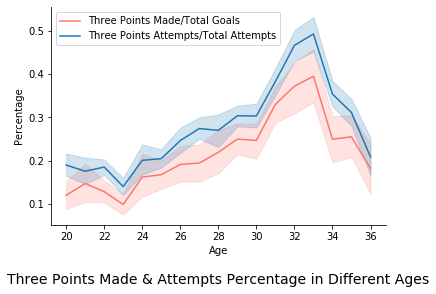

In [96]:
#Three Points
#Three Ponits Percentage
import seaborn as sns
line_one = sns.lineplot(x=active['Age'], y=(active['3P']/active['FG']),color = '#FC766A')
line_two = sns.lineplot(x=active['Age'], y=(active['3PA']/active['FGA']))
line_two.spines['right'].set_visible(False)
line_two.spines['top'].set_visible(False)
plt.legend(labels=['Three Points Made/Total Goals','Three Points Attempts/Total Attempts'])
line_two.set(ylabel='Percentage')
plt.title('Three Points Made & Attempts Percentage in Different Ages', y=-0.3, fontsize = 14)
plt.savefig("D:/plotlyplot/threepoints.jpg",bbox_inches='tight')

Text(0.5, -0.3, 'Free Throw Percentage in Different Ages')

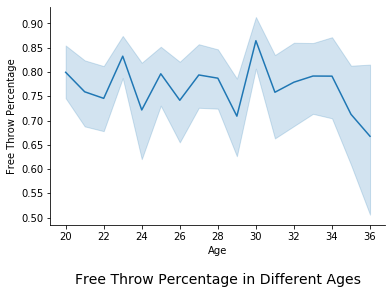

In [68]:
#Free Throw Percentage
line_three = sns.lineplot(x=active['Age'], y=(active['FT%']))
line_three.spines['right'].set_visible(False)
line_three.spines['top'].set_visible(False)
line_three.set(ylabel='Free Throw Percentage')
plt.title('Free Throw Percentage in Different Ages', y=-0.3, fontsize = 14)

Text(0.5, -0.3, 'Free Throw Attempts in Different Ages')

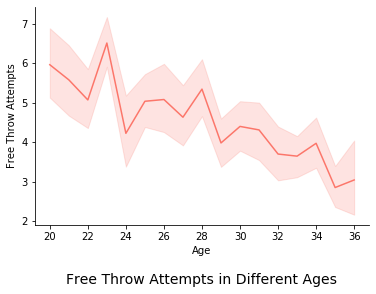

In [69]:
#Free Throw Attempts, showing the agreesive
line_four = sns.lineplot(x=active['Age'], y=(active['FTA']),color = '#FC766A')
line_four.spines['right'].set_visible(False)
line_four.spines['top'].set_visible(False)
line_four.set(ylabel='Free Throw Attempts')
plt.title('Free Throw Attempts in Different Ages', y=-0.3, fontsize = 14)

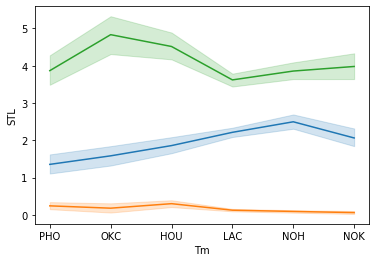

In [25]:
sns.lineplot(x="Tm", y="STL", data=active)
sns.lineplot(x="Tm", y="BLK", data=active)
sns.lineplot(x="Tm", y="DRB", data=active)

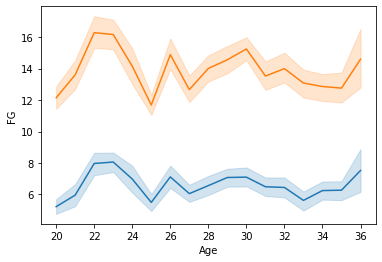

In [130]:
import seaborn as sns
sns.lineplot(x=active['Age'], y=(active['FG']))
sns.lineplot(x=active['Age'], y=(active['FGA']))

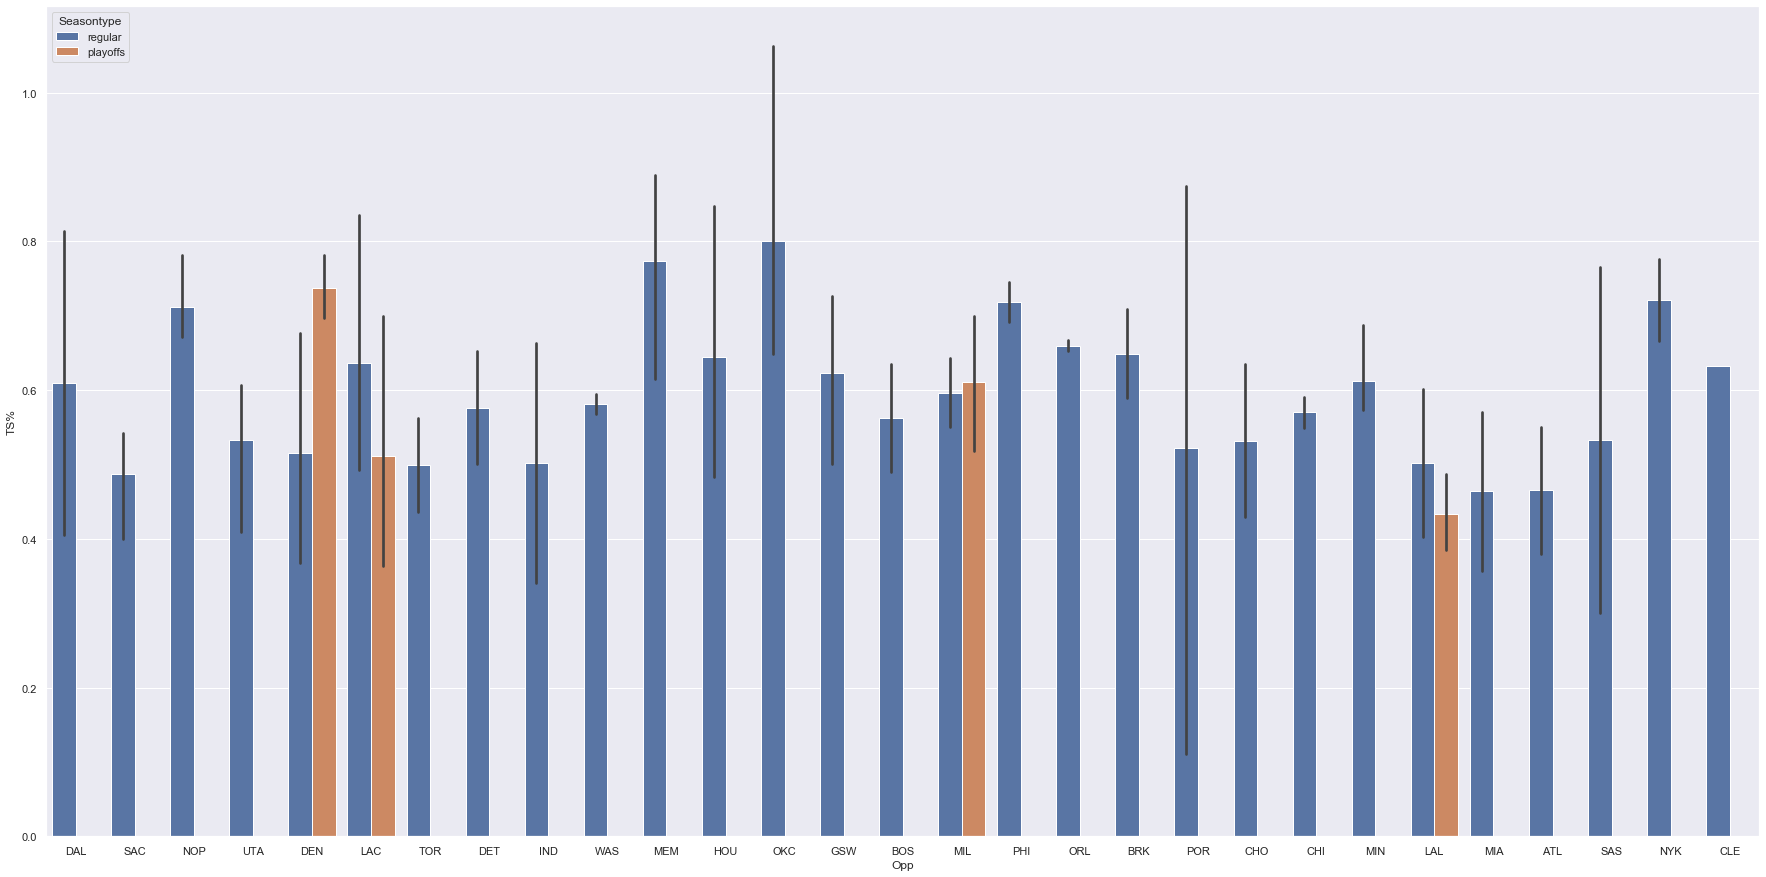

In [54]:
sns.barplot(x="Opp", y="TS%", hue = "Seasontype", data=phogame)
sns.set(rc={'figure.figsize':(30.7,15.27)})

Text(0.5, -0.3, 'Steals Number in Different Teams')

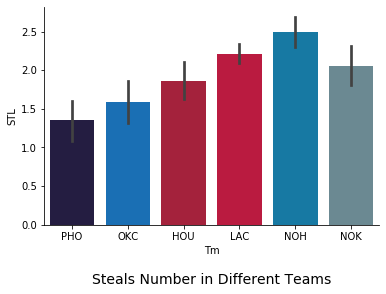

In [85]:
barone = sns.barplot(x="Tm", y="STL", data=active,palette = ['#201747','#0072CE','#BA0C2F','#D50032','#0082BA','#658C98'])
barone.spines['right'].set_visible(False)
barone.spines['top'].set_visible(False)
plt.title('Steals Number in Different Teams', y=-0.3, fontsize = 14)

Text(0.5, -0.3, 'Block Number in Different Teams')

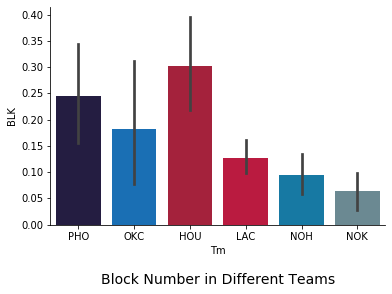

In [90]:
bartwo = sns.barplot(x="Tm", y="BLK", data=active,palette = ['#201747','#0072CE','#BA0C2F','#D50032','#0082BA','#658C98'])
bartwo.spines['right'].set_visible(False)
bartwo.spines['top'].set_visible(False)
plt.title('Block Number in Different Teams', y=-0.3, fontsize = 14)

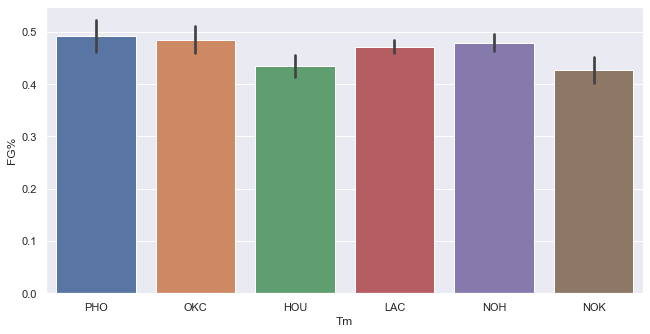

In [30]:
sns.barplot(x="Tm", y="FG%", data=active)
sns.set(rc={'figure.figsize':(10.7,5.27)})

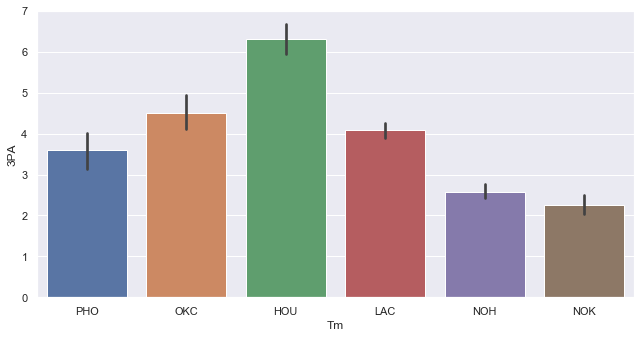

In [31]:
sns.barplot(x="Tm", y="3PA", data=active)
sns.set(rc={'figure.figsize':(10.7,5.27)})

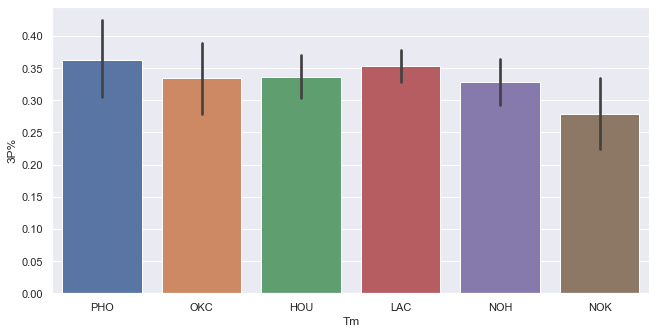

In [52]:
sns.barplot(x="Tm", y="3P%", data=active)
sns.set(rc={'figure.figsize':(10.7,5.27)})

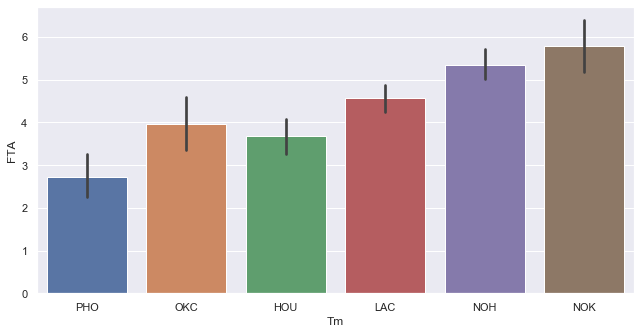

In [34]:
sns.barplot(x="Tm", y="FTA", data=active)
sns.set(rc={'figure.figsize':(10.7,5.27)})

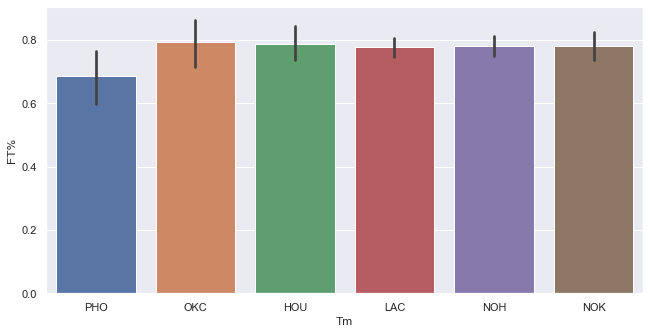

In [50]:
sns.barplot(x="Tm", y="FT%", data=active)

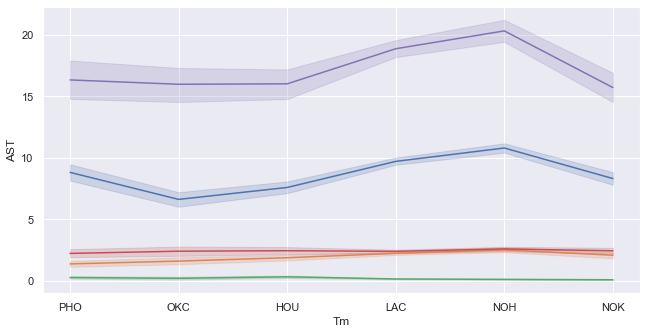

In [48]:
sns.lineplot(x="Tm", y="AST", data=active)
sns.lineplot(x="Tm", y="STL", data=active)
sns.lineplot(x="Tm", y="BLK", data=active)
sns.lineplot(x="Tm", y="TOV", data=active)
sns.lineplot(x="Tm", y="GmSc", data=active)

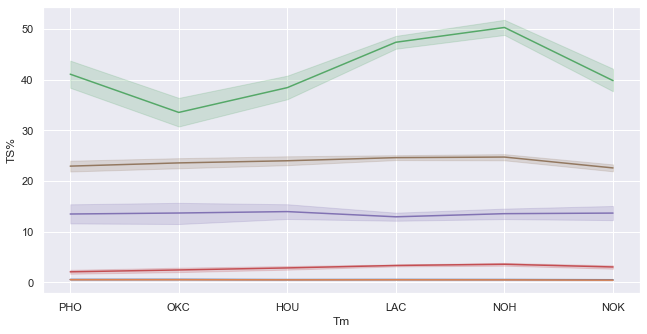

In [56]:
sns.lineplot(x="Tm", y="TS%", data=active)
sns.lineplot(x="Tm", y="eFG%", data=active)
sns.lineplot(x="Tm", y="AST%", data=active)
sns.lineplot(x="Tm", y="STL%", data=active)
sns.lineplot(x="Tm", y="TOV%", data=active)
sns.lineplot(x="Tm", y="USG%", data=active)

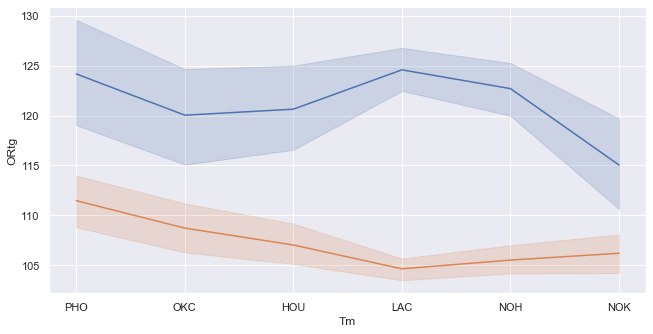

In [59]:
sns.lineplot(x="Tm", y="ORtg", data=active)
sns.lineplot(x="Tm", y="DRtg", data=active)

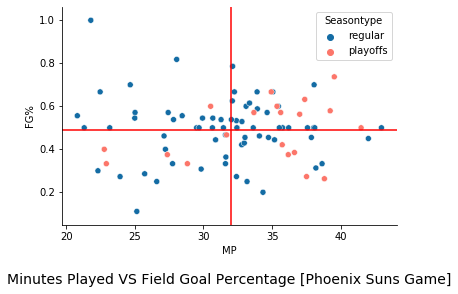

In [95]:
point_one = sns.scatterplot(x="MP", y="FG%", hue = "Seasontype", data=phogame, palette=['#146ca4','#FC766A'])
plt.axvline(x=phogame.MP.mean(),
            color='red')
plt.axhline(y=phogame['FG%'].mean(),
            color='red')
point_one.spines['right'].set_visible(False)
point_one.spines['top'].set_visible(False)
plt.title('Minutes Played VS Field Goal Percentage [Phoenix Suns Game]', y=-0.3, fontsize = 14)
plt.savefig("D:/plotlyplot/minutesvsfg.jpg",bbox_inches='tight')

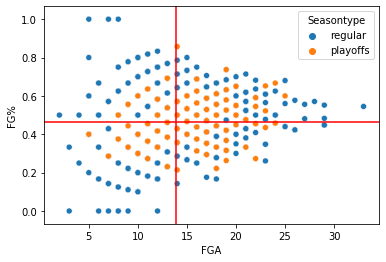

In [28]:
import seaborn as sns
sns.scatterplot(x="FGA", y="FG%", hue = 'Seasontype',data=active)
plt.axvline(x=active.FGA.mean(),
            color='red')
plt.axhline(y=active['FG%'].mean(),
            color='red')

In [6]:
response = shotchartdetail.ShotChartDetail(
    context_measure_simple = "FGA",
    team_id=0,
    player_id=101108,
    season_nullable='2020-21',
    season_type_all_star='Playoffs')
content = json.loads(response.get_json())
#Regular Season

In [7]:
results = content['resultSets'][0]
headers = results['headers']
rows = results['rowSet']
df = pd.DataFrame(rows)
df.columns = headers

In [9]:
df.to_csv('D:/ANLY503/midpoint/shotlog_example.csv', encoding='utf-8',index = False)

In [38]:
df.groupby(['SHOT_MADE_FLAG']).size()

SHOT_MADE_FLAG
0    151
1    149
dtype: int64

In [7]:
#Reference from https://github.com/hkair/nba-shotcharts
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
    # Create the various parts of an NBA basketball court; Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)
    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop

    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

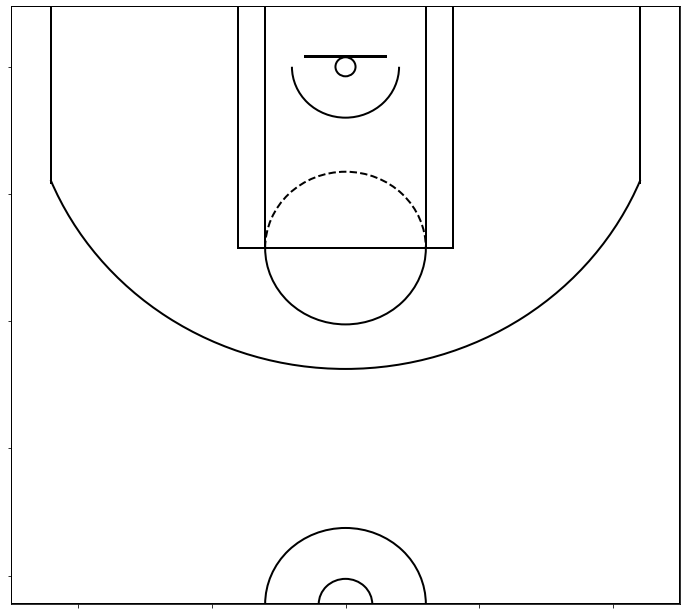

In [15]:
plt.figure(figsize=(12,11))
draw_court(outer_lines=True)
plt.ylim(-100,500)
plt.xlim(-250,250)
# Descending values along th y axis from bottom to top
# in order to place the hoop by the top of plot
plt.ylim(422.5, -47.5)
# get rid of axis tick labels
plt.tick_params(labelbottom=False, labelleft=False)
plt.show()
plt.show()